# **Declare path to project directory**

In [1]:
path_to_directory = "/home/antonio/ist/data-science/proj/classification"

# **Classification**

In [2]:
from numpy import array, ndarray
from pandas import read_csv, DataFrame
import os

In [3]:
file_tag = "class_financial distress"
index_col = None
target = "CLASS"
index_col = None
data: DataFrame = read_csv(f"datasets/{file_tag}_oversampling.csv", index_col=index_col)
# Remove the "Financial Distress" column
if "Financial Distress" in data.columns:
    data.drop(columns=["Financial Distress"], inplace=True)

labels: list = list(data[target].unique())
labels.sort()
print(f"Labels={labels}")

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == negative]),
        len(data[data[target] == positive]),
    ]
}

y: array = data.pop(target).to_list()
X: ndarray = data.values

Labels=[np.int64(0), np.int64(1)]


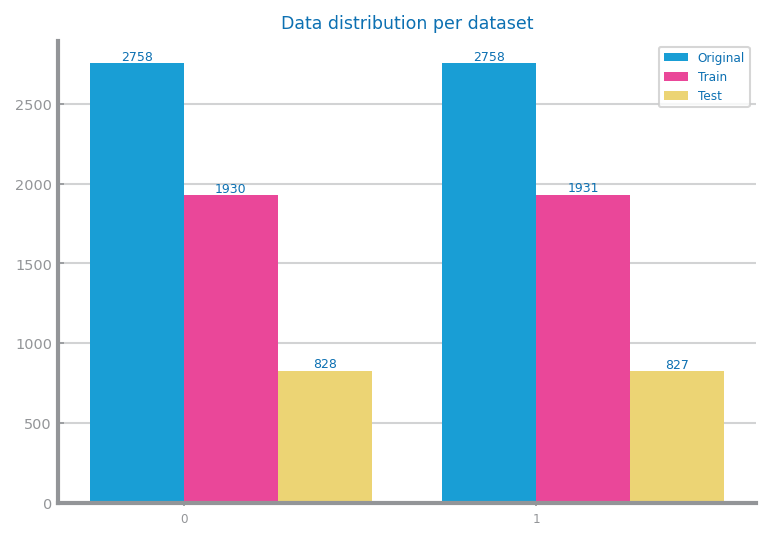

In [4]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train: DataFrame = concat(
    [DataFrame(trnX, columns=data.columns), DataFrame(trnY, columns=[target])], axis=1
)
train.to_csv(f"datasets/{file_tag}_train.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX, columns=data.columns), DataFrame(tstY, columns=[target])], axis=1
)
test.to_csv(f"datasets/{file_tag}_test.csv", index=False)

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

In [5]:
from pandas import read_csv


def read_train_test_from_files(
    train_fn: str, test_fn: str, target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    train: DataFrame = read_csv(train_fn, index_col=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    test: DataFrame = read_csv(test_fn, index_col=None)
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()

eval_metric = "accuracy"
train_filename = f"datasets/{file_tag}_train.csv"
test_filename = f"datasets/{file_tag}_test.csv"

trnX: ndarray
tstX: ndarray
trnY: array
tstY: array
labels: list
vars: list
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=3861 Test#=1655
Labels=[np.int64(0), np.int64(1)]


# NB

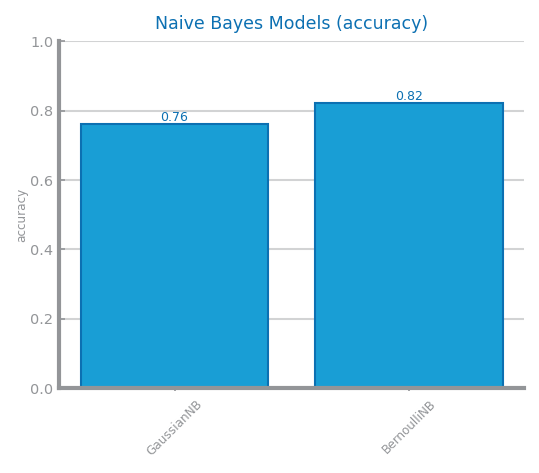

In [6]:
from numpy import array, ndarray
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart


def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

eval_metric = "accuracy"
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"images/{file_tag}_nb_{eval_metric}_study.png")
show()

## Evaluation

### Recall

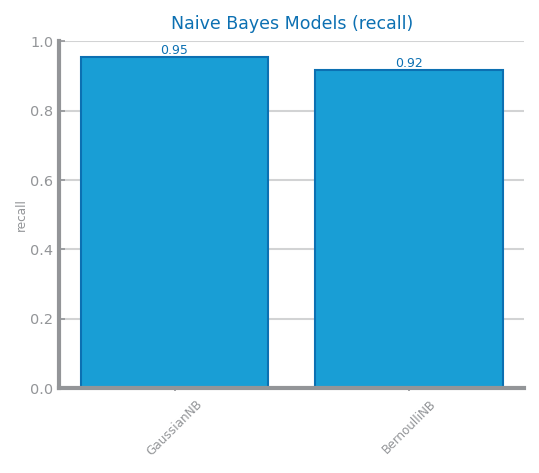

In [7]:
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, "recall")
savefig(f"images/{file_tag}_nb_recall_study.png")
show()

### Performance Analysis

<Figure size 600x450 with 0 Axes>

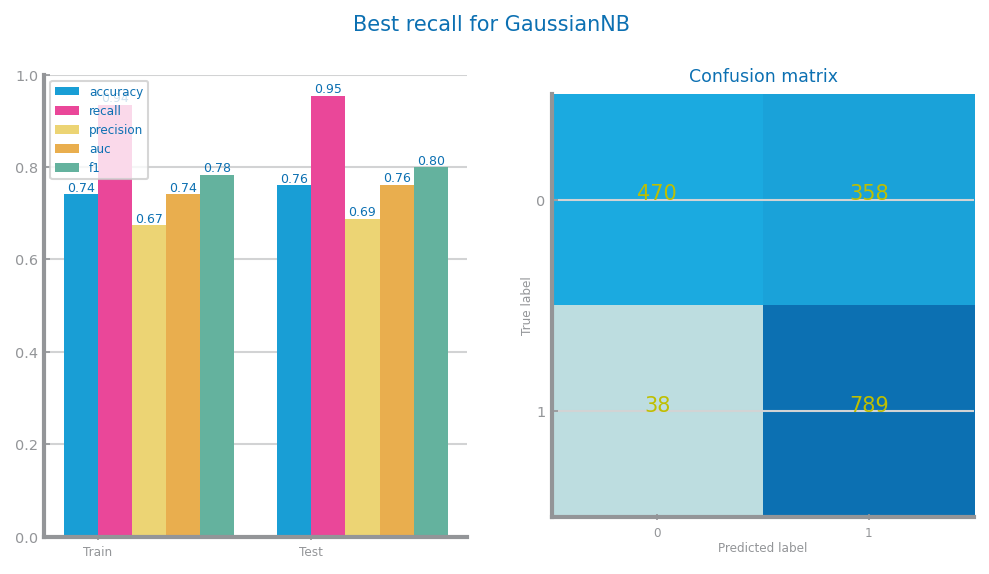

In [8]:
from dslabs_functions import plot_evaluation_results

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_{params["name"]}_best_{params["metric"]}_eval.png')
show()

# KNN

Train#=3861 Test#=1655
Labels=[np.int64(0), np.int64(1)]
KNN best with k=1 and chebyshev


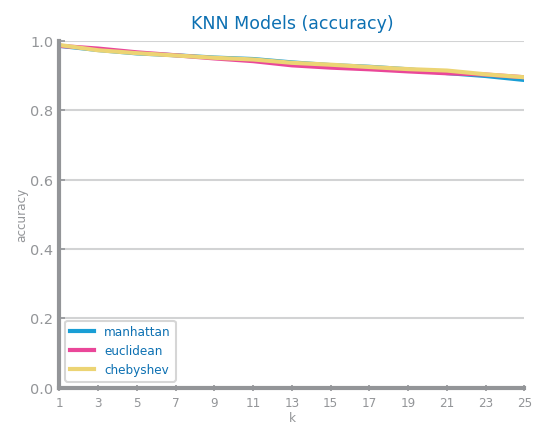

In [9]:
from typing import Literal
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from dslabs_functions import read_train_test_from_files, plot_evaluation_results

def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f'KNN best with k={best_params['params'][0]} and {best_params['params'][1]}')
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
savefig(f'images/{file_tag}_knn_{eval_metric}_study.png')
show()

## Best model performance

<Figure size 600x450 with 0 Axes>

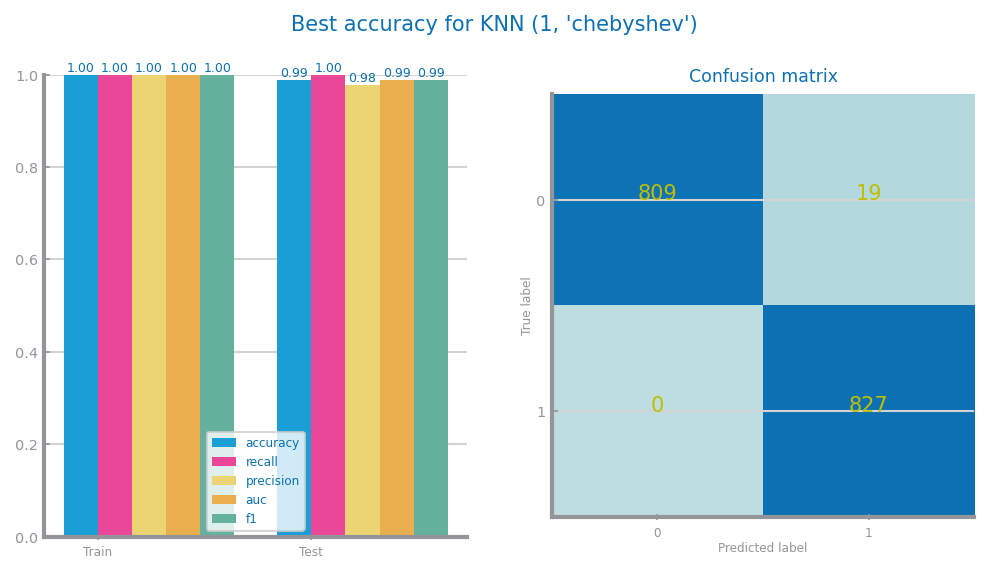

In [10]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_knn_{params["name"]}_best_{params["metric"]}_eval.png')
show()

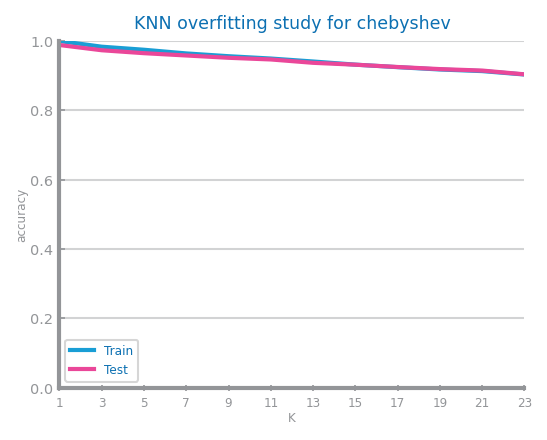

In [11]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_overfitting.png")
show()

# Decision Trees

## Paremeters study

Train#=3861 Test#=1655
Labels=[np.int64(0), np.int64(1)]
DT best with entropy and d=18


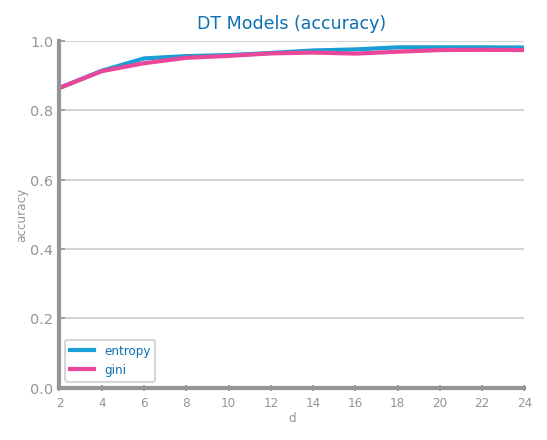

In [12]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_evaluation_results, plot_multiline_chart


def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f'DT best with {best_params['params'][0]} and d={best_params['params'][1]}')
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
show()

<Figure size 600x450 with 0 Axes>

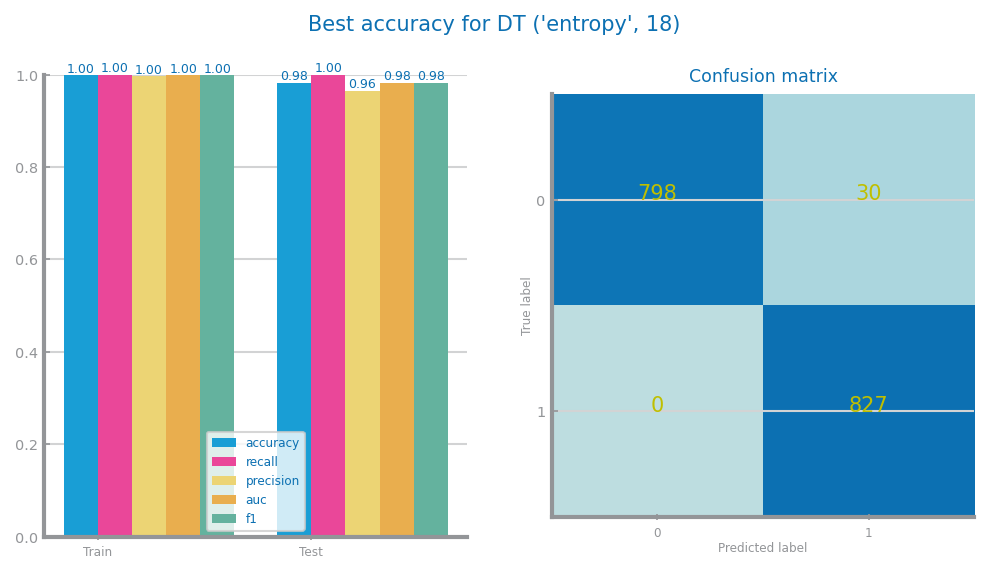

In [13]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
show()

### Variables importance

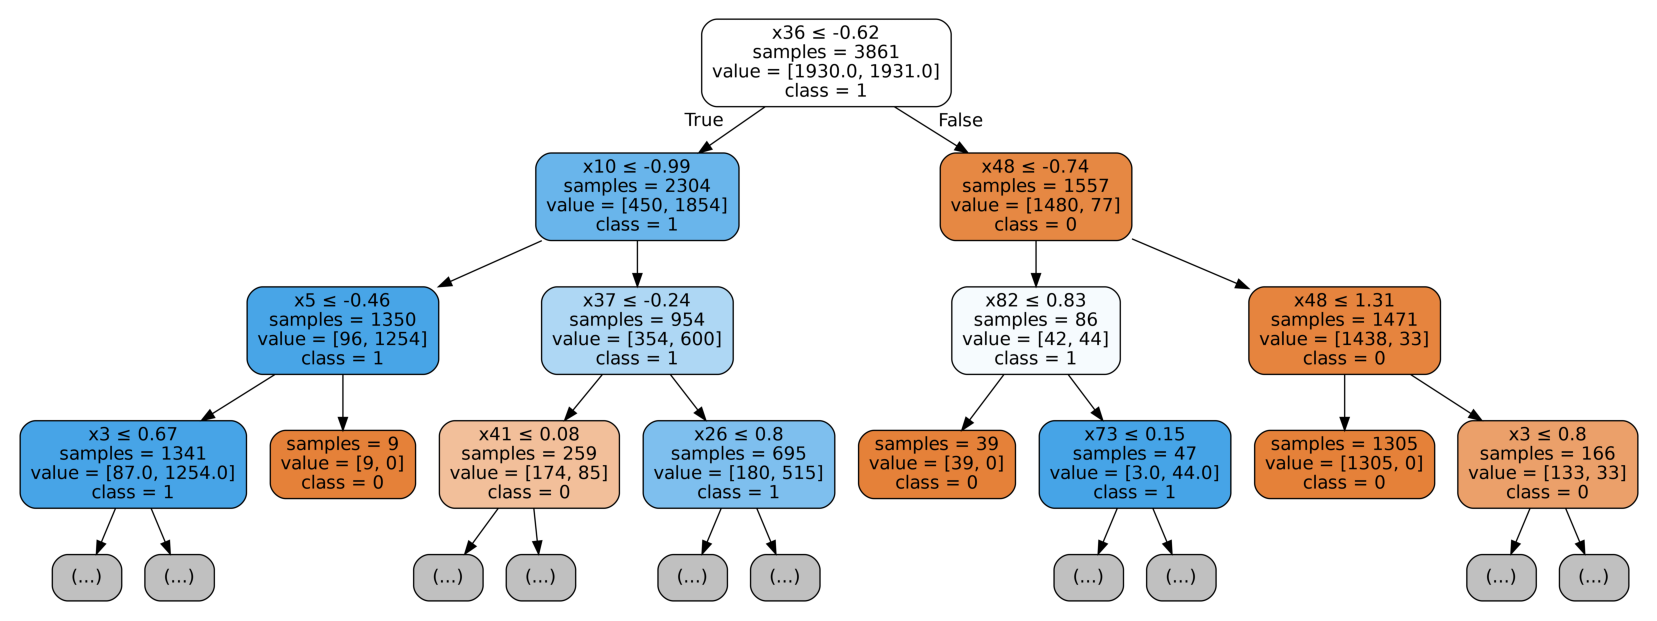

In [14]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

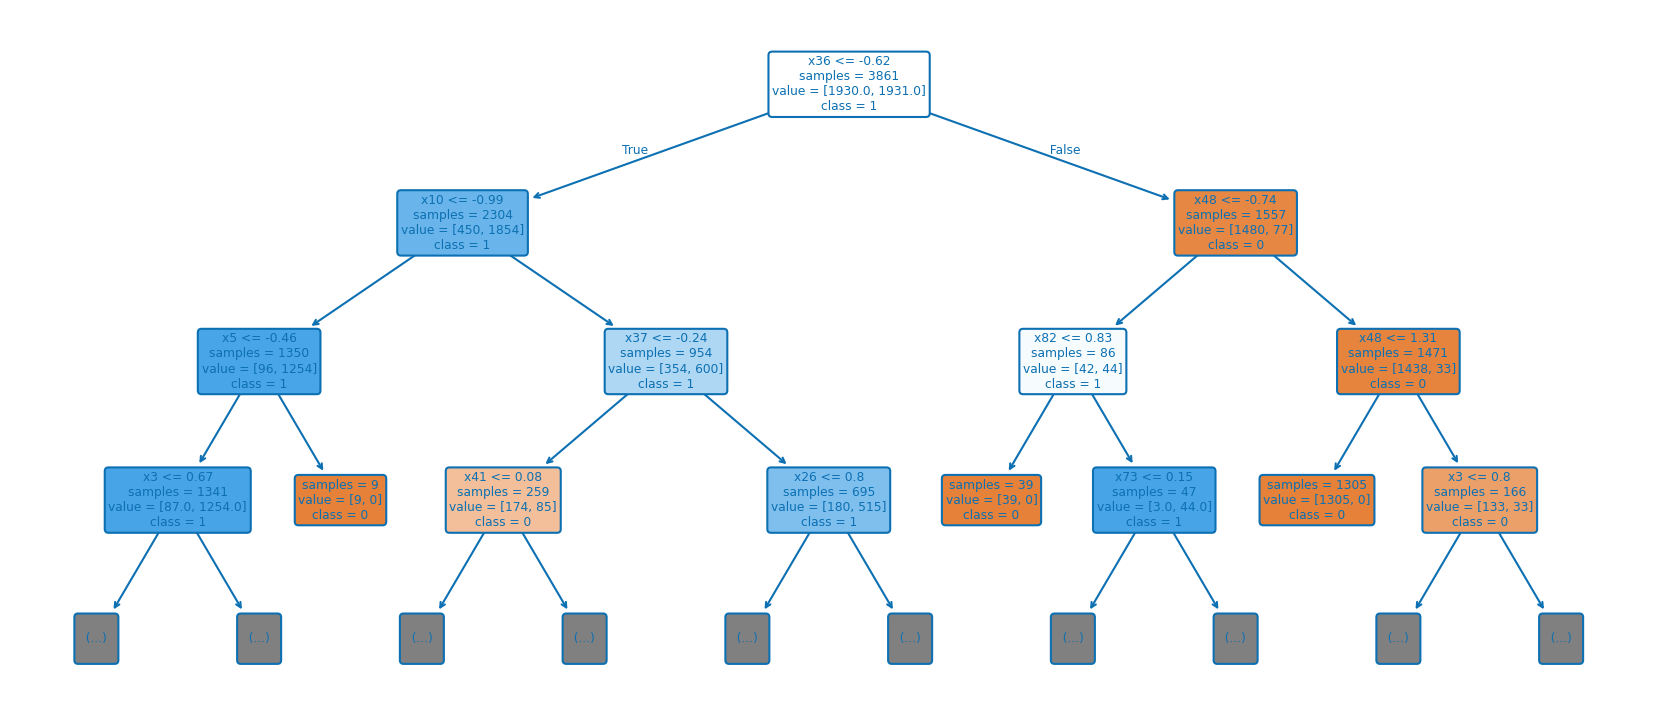

In [15]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + ".png")

1. x36 (0.47351508193286557)
2. x10 (0.07472708530208329)
3. x48 (0.06833735944715792)
4. x3 (0.032054386634660106)
5. x26 (0.03170838591044079)
6. x39 (0.0257705203103013)
7. x37 (0.02562199400510258)
8. x41 (0.024148592042131718)
9. x21 (0.02192688466932471)
10. x82 (0.01832214876128949)
11. x80 (0.01654669329695581)
12. x27 (0.01417058060093952)
13. x11 (0.013669547692622637)
14. x51 (0.013264528790815217)
15. x7 (0.011638565830990098)
16. x5 (0.011586825063409037)
17. x20 (0.011135925518942892)
18. x77 (0.01082646193685816)
19. x60 (0.010784057609547312)
20. x50 (0.010613196504042603)
21. x78 (0.008255773140567023)
22. x2 (0.007422303453701954)
23. x30 (0.0067534005173733895)
24. x57 (0.006252777447416469)
25. x23 (0.006229046825865914)
26. x45 (0.005035752465176895)
27. x44 (0.0049500719144994435)
28. x58 (0.004571939075782684)
29. x31 (0.004307988890830092)
30. x73 (0.004220793688114121)
31. x4 (0.0038344759756905856)
32. x83 (0.0034956026342228266)
33. x28 (0.002751642397745406)

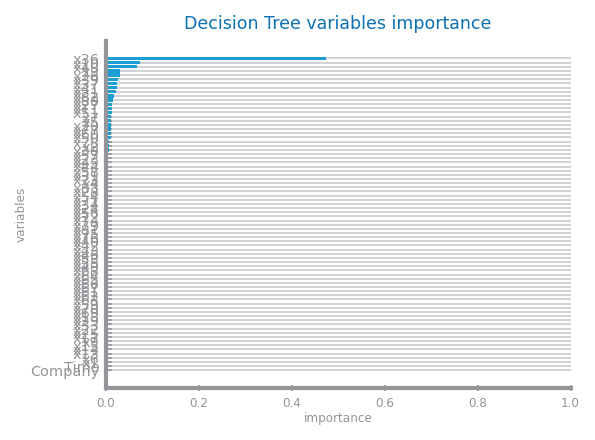

In [16]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_vars_ranking.png")

### Overfitting study

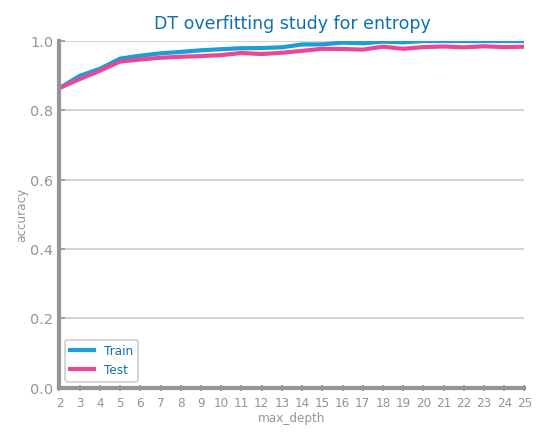

In [17]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")